In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
def Gauss(m,v,x):
    """
    Gaussian function
    Needs numpy as np
    Input: mean and variance
    Output: Gaussian that meets the description at position x
    """
    return np.exp(-(x-m)**2/(2*v))/(np.sqrt(2*np.pi*v))
def lGauss(m,v,x):
    """
    Gaussian function
    Needs numpy as np
    Input: mean and variance
    Output: Log( Gaussian that meets the description at position x )
    """
    return (-(x-m)**2/(2*v))-np.log((np.sqrt(2*np.pi*v)))

In [ ]:
def Integrate(f2, low, up, N, pxi, xi, pxs, pygx, lpygx, xs, SNR, Gauss, lGauss, a, pa):
    """
    Integrate a function using trapezoidal rule
    Needs numpy as np
    Input: function to be integrated, lower bound, upper bound, number of increments
    Output: Result of integration (must be a number)
    """
    pts = np.linspace(low, up, N)
    sums = 0
    for pt in pts:
        sums = sums + f2(pt, pxi, xi, pxs, pygx, lpygx, xs, SNR, Gauss, lGauss, a, pa)
    sums = sums - f2(low, pxi, xi, pxs, pygx, lpygx, xs, SNR, Gauss, lGauss, a, pa)/2 - f2(up, pxi, xi, pxs, pygx, lpygx, xs, SNR, Gauss, lGauss, a, pa)/2
    sums = sums*(up-low)/N
    return sums

In [ ]:
def pygx(yi, xi, SNR, Gauss):
    """
    Assumes AWGN out from input x
    Needs numpy as np
    Input: x value
    Output: probabilty of y given x in y
    """
    v = 10**(-SNR/10)
    return Gauss(xi,v,yi)
def lpygx(yi, xi, SNR, lGauss):
    """
    Assumes AWGN out from input x
    Needs numpy as np
    Input: x value
    Output: log( probabilty of y given x in y )
    """
    v = 10**(-SNR/10)
    return lGauss(xi,v,yi)

In [ ]:
def xs(a, pa):
    return np.array([-np.sqrt((0.5-(a**2)*pa)/(0.5-pa)),-a,a,np.sqrt((0.5-(a**2)*pa)/(0.5-pa))])

In [ ]:
def pxs(pa):
    return np.array([0.5-pa,pa,pa,0.5-pa])

In [ ]:
def f2(yi, pxi, xi, pxs, pygx, lpygx, xs, SNR, Gauss, lGauss, a, pa):
    """
    Function to be integrated
    Needs numpy as np
    Input: component of function
    Output: output of the function at a certain point
    """
    den = 0
    xss = xs(a, pa)
    pxss = pxs(pa)
    for j in range(len(xss)):
        den = den + pxss[j]*pygx(yi, xss[j], SNR, Gauss)
    lpygxi = lpygx(yi, xi, SNR, lGauss)
    pygxi = pygx(yi, xi, SNR, Gauss)
    return pxi*pygxi*(lpygxi-np.log(den))/np.log(2)

In [ ]:
def MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a, pa):
    """
    Mutual information
    Needs numpy as np
    Input: x discrete, y continuous, z continuous
    Outputs: value of mutual information
    """
    insum = 0
    xss = xs(a, pa)
    pxss = pxs(pa)
    for i in range(len(xss)):
        insum = insum + Integrate(f2, low, up, N, pxss[i], xss[i], pxs, pygx, lpygx, xs, SNR, Gauss, lGauss, a, pa)
    return insum

In [ ]:
def grad_descent(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a, pa, numdif, step):
    """
    Gradient Descent of MI_disc_cont
    Input: starting a and pa; hyperparameter numdif and step
    Output: stable a and pa which minimizes MI_disc_cont
    """
    da = 0
    dpa = 0
    starting = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a, pa)
    ga = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a+numdif, pa)
    gpa = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a, pa+numdif)
    va = (ga - starting)/numdif
    vpa = (gpa - starting)/numdif
    print("a =", a)
    print("pa =", pa)
    print("b =", np.sqrt((0.5-(a**2)*pa)/(0.5-pa)))
    print("pb =", 0.5-pa)
    prev = 0
    while prev < starting:
        hatva = va/(np.sqrt(va**2+vpa**2))
        hatvpa = vpa/(np.sqrt(va**2+vpa**2))
        prev = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a+da, pa+dpa)
        da += step*hatva
        dpa += step*hatvpa
        va_prev = (ga - starting)/numdif
        vpa_prev = (gpa - starting)/numdif
        starting = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a+da, pa+dpa)
        ga = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a+da+numdif, pa+dpa)
        gpa = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a+da, pa+dpa+numdif)
        va = (ga - starting)/numdif
        vpa = (gpa - starting)/numdif
    da -= step*hatva
    dpa -= step*hatvpa
    starting = MI_disc_cont(xs, pxs, pygx, lpygx, Integrate, low, up, N, SNR, Gauss, lGauss, a+da, pa+dpa)
    return np.array([starting, a+da, pa+dpa])

In [10]:
a = 0.8
pa = 0.25
N = 2000
k = np.linspace(-10, 20, 61)
aas = np.zeros(len(k))
paas = np.zeros(len(k))
Hs = np.zeros(len(k))
for l in range(len(k)):
    up = 4.5 + 0.1*(20-k[l])
    low = -4.5 - 0.1*(20-k[l])
    res = grad_descent(xs, pxs, pygx, lpygx, Integrate, low, up, N, k[l], Gauss, lGauss, a, pa, numdif=0.003, step=0.003)
    print("SNR =", k[l])
    print(res)
    Hs[l] = res[0]
    aas[l] = res[1]
    paas[l] = res[2]

a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -10.0
[0.05962943 0.99923105 0.15625087]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -9.5
[0.06884362 0.99918725 0.15617101]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -9.0
[0.07894931 0.99912615 0.15605969]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -8.5
[0.08996752 0.999042   0.15590651]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -8.0
[0.10192829 0.99892631 0.15569619]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -7.5
[0.11487636 0.99876502 0.15540347]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -7.0
[0.12887526 0.99853019 0.15497831]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -6.5
[0.14400857 1.00114716 0.15415416]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -6.0
[0.16037786 1.00035605 0.15278442]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25
SNR = -5.5
[0.17809745 0.99959068 0.14606841]
a = 0.8
pa = 0.25
b = 1.16619037896906
pb = 0.25


In [11]:
paas

array([0.15625087, 0.15617101, 0.15605969, 0.15590651, 0.15569619,
       0.15540347, 0.15497831, 0.15415416, 0.15278442, 0.14606841,
       0.18520404, 0.26912494, 0.31399207, 0.39512071, 0.42727334,
       0.43067395, 0.43254399, 0.43340455, 0.43337573, 0.43314678,
       0.43280065, 0.43233602, 0.43170492, 0.43079008, 0.4293682 ,
       0.42732577, 0.4249057 , 0.42180321, 0.41411814, 0.40365506,
       0.39637226, 0.3912213 , 0.38469013, 0.37877216, 0.37146798,
       0.36482141, 0.35784704, 0.35057655, 0.34304851, 0.33530794,
       0.32740606, 0.32041114, 0.31234982, 0.30528437, 0.29826441,
       0.29135953, 0.28465189, 0.27823872, 0.27292824, 0.26736493,
       0.26296169, 0.25911642, 0.25590367, 0.25360285, 0.25164267,
       0.25039718, 0.24974955, 0.25071518, 0.24939316, 0.24947828,
       0.24917755])

In [12]:
aas

array([0.99923105, 0.99918725, 0.99912615, 0.999042  , 0.99892631,
       0.99876502, 0.99853019, 1.00114716, 1.00035605, 0.99959068,
       0.05154951, 0.1184935 , 0.2598613 , 0.58549243, 0.67464115,
       0.67464301, 0.67282981, 0.67365344, 0.67362057, 0.67326874,
       0.67272133, 0.67199324, 0.67105133, 0.6698395 , 0.66836085,
       0.66687168, 0.66251037, 0.65541669, 0.6358882 , 0.60988231,
       0.59571804, 0.58695845, 0.57517716, 0.56607107, 0.55402713,
       0.54473779, 0.53542485, 0.52613402, 0.51690734, 0.50778045,
       0.49878002, 0.49274634, 0.48403956, 0.47831136, 0.47272497,
       0.46726067, 0.46189427, 0.45660074, 0.45427592, 0.44908626,
       0.44687628, 0.4447206 , 0.44261637, 0.44355529, 0.44156686,
       0.44263867, 0.44079026, 0.45453513, 0.47933118, 0.50475803,
       0.53021021])

In [13]:
Hs

array([0.05962943, 0.06884362, 0.07894931, 0.08996752, 0.10192829,
       0.11487636, 0.12887526, 0.14400857, 0.16037786, 0.17809745,
       0.19735094, 0.21837666, 0.24122624, 0.26594475, 0.29268961,
       0.32155981, 0.35260108, 0.38588307, 0.42146419, 0.45938557,
       0.49967021, 0.54232084, 0.58731842, 0.63462061, 0.68415936,
       0.73583138, 0.7895391 , 0.84516094, 0.90268701, 0.96179523,
       1.02214436, 1.0835932 , 1.14585189, 1.20860044, 1.27148913,
       1.33413668, 1.39612926, 1.45703042, 1.51638416, 1.57372254,
       1.62857532, 1.68049471, 1.72903813, 1.7738285 , 1.81452862,
       1.85089089, 1.88275929, 1.91008249, 1.93293148, 1.95150306,
       1.96611102, 1.97717342, 1.9851947 , 1.99073053, 1.9943386 ,
       1.99654217, 1.9978019 , 1.99844821, 1.99865198, 1.99874195,
       1.99878377])

In [14]:
pbbs = 0.5 - paas
pbbs

array([0.34374913, 0.34382899, 0.34394031, 0.34409349, 0.34430381,
       0.34459653, 0.34502169, 0.34584584, 0.34721558, 0.35393159,
       0.31479596, 0.23087506, 0.18600793, 0.10487929, 0.07272666,
       0.06932605, 0.06745601, 0.06659545, 0.06662427, 0.06685322,
       0.06719935, 0.06766398, 0.06829508, 0.06920992, 0.0706318 ,
       0.07267423, 0.0750943 , 0.07819679, 0.08588186, 0.09634494,
       0.10362774, 0.1087787 , 0.11530987, 0.12122784, 0.12853202,
       0.13517859, 0.14215296, 0.14942345, 0.15695149, 0.16469206,
       0.17259394, 0.17958886, 0.18765018, 0.19471563, 0.20173559,
       0.20864047, 0.21534811, 0.22176128, 0.22707176, 0.23263507,
       0.23703831, 0.24088358, 0.24409633, 0.24639715, 0.24835733,
       0.24960282, 0.25025045, 0.24928482, 0.25060684, 0.25052172,
       0.25082245])

In [15]:
bbs = np.sqrt((0.5-(aas**2)*paas)/(0.5-paas))
bbs

array([1.00034933, 1.00036894, 1.00039625, 1.00043376, 1.00048515,
       1.00055644, 1.00065951, 0.99948825, 0.99984329, 1.00016888,
       1.25966941, 1.46605138, 1.60438974, 1.86438208, 2.04965362,
       2.09399419, 2.12353912, 2.1341561 , 2.13380803, 2.13123626,
       2.12740515, 2.12229547, 2.11534522, 2.10513759, 2.08888796,
       2.06520437, 2.04322201, 2.01914948, 1.96778473, 1.90559841,
       1.86213859, 1.83232781, 1.79790168, 1.76727827, 1.73291147,
       1.70234178, 1.67202513, 1.64217183, 1.6129768 , 1.58461756,
       1.55725442, 1.53328092, 1.50815848, 1.48632177, 1.46563803,
       1.44622709, 1.42822134, 1.41177066, 1.39782165, 1.38473903,
       1.37398162, 1.36489747, 1.35756619, 1.35157293, 1.34746715,
       1.34410936, 1.34316465, 1.34087666, 1.32910171, 1.3198922 ,
       1.30926037])

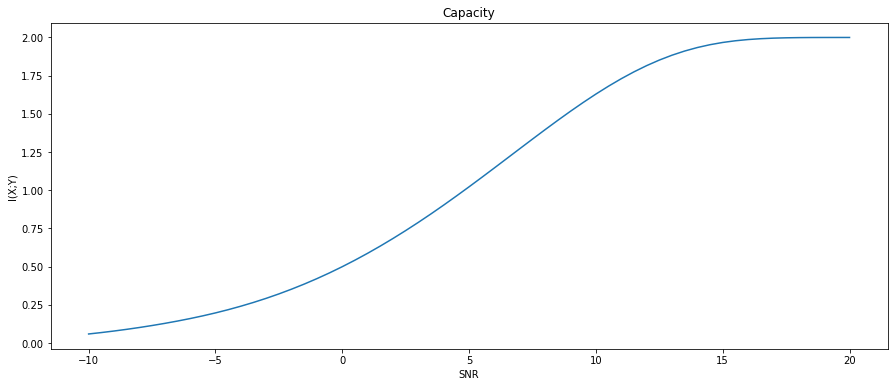

In [16]:
plt.figure(figsize=(15,6))
plt.plot(k,Hs)
plt.title("Capacity")
plt.xlabel("SNR")
plt.ylabel("I(X;Y)")
plt.show()

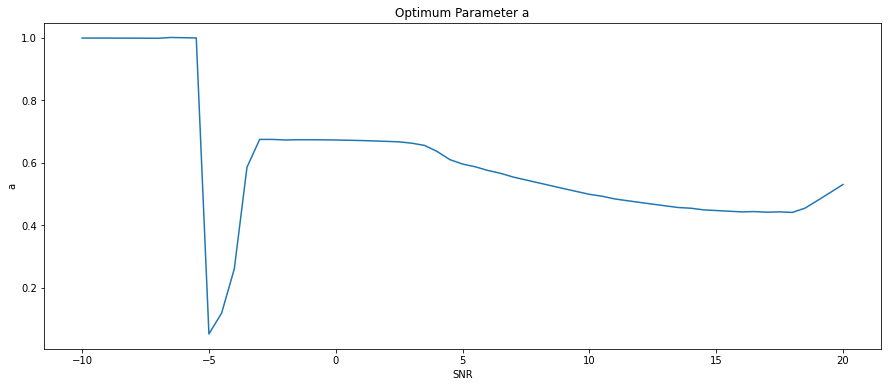

In [17]:
plt.figure(figsize=(15,6))
plt.plot(k,aas)
plt.title("Optimum Parameter a")
plt.xlabel("SNR")
plt.ylabel("a")
plt.show()

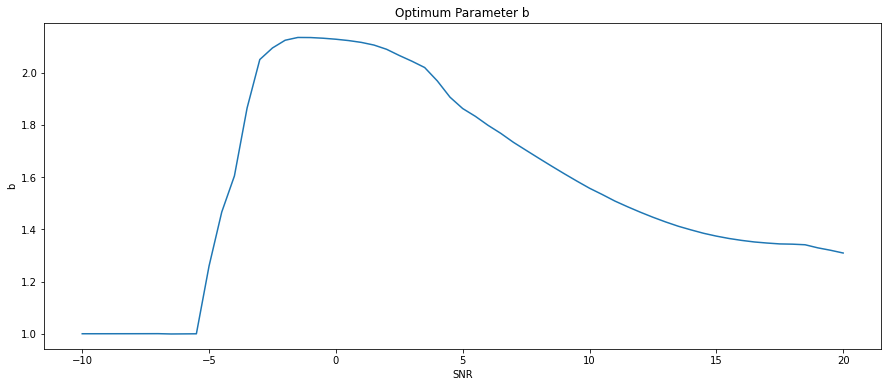

In [18]:
plt.figure(figsize=(15,6))
plt.plot(k,bbs)
plt.title("Optimum Parameter b")
plt.xlabel("SNR")
plt.ylabel("b")
plt.show()

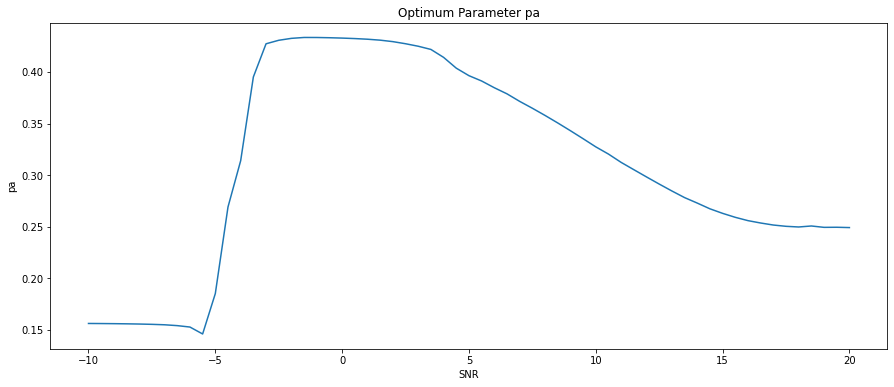

In [19]:
plt.figure(figsize=(15,6))
plt.plot(k,paas)
plt.title("Optimum Parameter pa")
plt.xlabel("SNR")
plt.ylabel("pa")
plt.show()

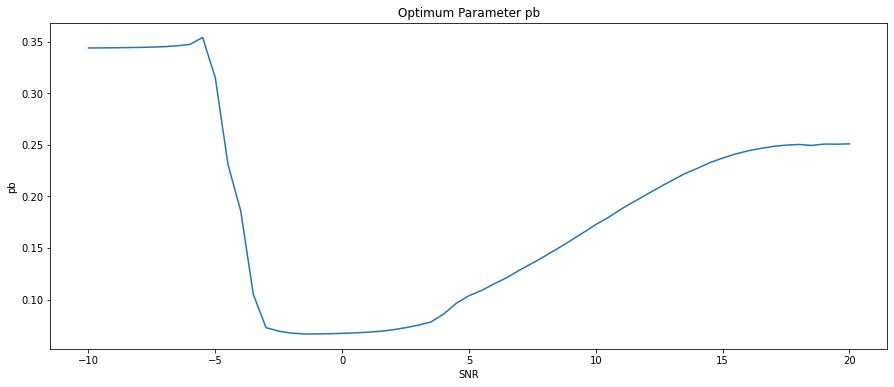

In [20]:
plt.figure(figsize=(15,6))
plt.plot(k,pbbs)
plt.title("Optimum Parameter pb")
plt.xlabel("SNR")
plt.ylabel("pb")
plt.show()